# Desafío Spike Septiembre 2020 - Predicción de desviación de precios en el sistema eléctrico chileno

### 1. Costos marginales


- Carga el archivo costo_marginal_real.csvEstos son los costos marginales reales observados.
- Carga el archivo costo_marginal_programado.csv. Estos son los costos marginales previstos por el sistema.
- Haz un merge del costos marginal real con el costo marginal programado a nivel de barra (*Ayuda: la columna de join no se llama igual en ambas bases! Los datos venían así del SIC *). Llama a esta nueva base costo_marginal
- Realiza un análisis exploratorio de la base resultante. ¿Qué puedes decir de las distintas variables? ¿Cómo distribuyen? En particular analiza las barras (barra_mnemotecnico). ¿Para cuántas barras se programa el costo? ¿Qué porcentaje es del total de barras que puedes observar en la base?

In [2]:
import pandas as pd

In [3]:
c_mreal = pd.read_csv("data/costo_marginal_real.csv")
c_mprogramado = pd.read_csv("data/costo_marginal_programado.csv")

In [4]:
c_mreal.head()

,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha,hora,costo_en_dolares,costo_en_pesos,nombre
0,BA01T005SE075T005,BA02T002SE032T002,2019-04-06,25,62.24,41.47176,BA S/E LORETO 15KV
1,BA01T005SE175T005,BA02T002SE032T002,2019-04-06,25,62.56,41.68498,BA S/E RETIRO 13.2KV
2,BA03R002SE002R002,BA02T002SE032T002,2019-04-06,25,60.04,40.00585,BA S/E ALTAMIRANO 12.5KV BP1
3,BA01R002SE012R002,BA02T002SE032T002,2019-04-06,25,61.65,41.07863,BA S/E CURACAVI 44KV B1
4,BA03R002SE013R002,BA02T002SE032T002,2019-04-06,25,59.55,39.67936,BA S/E EL MANZANO (ENEL DISTRIBUCIÓN) 23KV BP1


In [5]:
c_mreal.shape

(4309951, 7)

Obtenemos una submuestra de cada conjunto de datos ya que al hacer el join con todas las observaciones de ambos datasets, se cae el sistema. 

In [6]:
c_mreal_sub = c_mreal.sample(frac=0.3, replace=False, random_state=123).sort_values(['fecha', 'hora'])

In [7]:
c_mprogramado_sub = c_mprogramado.sample(frac=0.3, replace=False, random_state=123).sort_values(['fecha', 'hora'])

Miramos los datasets, sus dimensiones, variables y el tipo de variables que hay en cada una. 
Primero revisamos el dataset de costos marginales reales.

In [8]:
c_mreal_sub.shape

(1292985, 7)

In [9]:
c_mreal_sub.dtypes

barra_mnemotecnico                object
barra_referencia_mnemotecnico     object
fecha                             object
hora                               int64
costo_en_dolares                 float64
costo_en_pesos                   float64
nombre                            object
dtype: object

In [10]:
len(c_mreal_sub['barra_mnemotecnico'].unique())

1020

In [11]:
print(c_mreal_sub['fecha'].unique().min())
print(c_mreal_sub['fecha'].unique().max())

2019-01-01
2019-06-30


En el dataset de costos marginales reales, hay 7 variables, solo las variables 'hora', 'costo_en_dolares' y 'costo_en_pesos' son variables numéricas (las dos últimas con decimales), las demás son de tipo caracter. Cada fila indica el costo marginal para cada barra en una fecha y hora determinadas. En este subconjunto de datos obtenido de forma aleatoria, hay información sobre 1020 barras, entre el 01 de Enero y el 30 de Junio de 2019.

Revisamos si hay datos duplicados, y vemos que no los hay

In [12]:
len(c_mreal_sub[c_mreal_sub.duplicated(['barra_mnemotecnico', 'fecha', 'hora'])])

0

Ahora revisamos el dataset de costos marginales programados.

In [13]:
len(c_mprogramado_sub[c_mprogramado_sub.duplicated(['mnemotecnico_barra', 'fecha', 'hora'])])

50681

In [14]:
c_mprogramado_sub[c_mprogramado_sub.duplicated(['mnemotecnico_barra', 'fecha', 'hora'])]['mnemotecnico_barra'].unique()

array(['-', 'BA83L131SE134L131', 'BA02T003SE004T003', 'BA01T002SE036T002'],
      dtype=object)

Se han detectado 60.681 filas duplicadas (considerando barras que tienen la misma fecha y hora, cada uno con sus costos programados por separado). Lo ideal sería conocer cómo se construyó este conjunto de datos para decidir qué hacer, sin embargo ya que no se cuenta con más información al respecto, por ahora se eliminarán los duplicados. También, se han detectado barras con el nombre '-', es decir que son filas que parecen no tener nombre. Estas también las eliminaremos por ahora, pero nuevamente, lo ideal sería estudiar estos datos anómalos y tomar la decisión con mayor conocimiento de causa.

In [15]:
c_mprogramado_sub = c_mprogramado_sub.drop_duplicates(['mnemotecnico_barra', 'fecha', 'hora'], keep = 'first')
c_mprogramado_sub = c_mprogramado_sub[c_mprogramado_sub.mnemotecnico_barra != '-']

In [16]:
c_mprogramado_sub.shape

(302611, 5)

In [17]:
c_mprogramado_sub.dtypes

mnemotecnico_barra     object
nombre_barra           object
fecha                  object
hora                    int64
costo                 float64
dtype: object

In [18]:
len(c_mprogramado_sub['mnemotecnico_barra'].unique())

238

In [19]:
print(c_mprogramado_sub['fecha'].unique().min())
print(c_mprogramado_sub['fecha'].unique().max())

2019-01-01
2019-06-30


En el dataset de costos marginales progrmados, hay 5 variables. Solo las variables 'hora' y 'costo'  son variables numéricas (la última con decimales), las demás son de tipo caracter. Cada fila indica el costo marginal para cada barra en una fecha y hora determinadas, al igual que en el conjunto de datos de costos marginales reales. Según las instrucciones del desafío el costo está en USD en este datasaet. Finalmente, en este subconjunto de datos obtenido de forma aleatoria, hay información sobre 238 barras, entre el 01 de Enero y el 30 de Junio de 2019.

#### Merge de datasets

Nos damos cuenta a continuación que las horas en ambos datasets van de 1 a 25, lo cual es extraño. En este caso averiguaría con la fuente qué significa el valor 25. Sin embargo, por ahora asumiremos que no es un valor relevante ya que solo hay 23-36 observaciones con ese valor, vs alrededor de 2500-9000 observaciones en los otros valores, respectivamente en cada dataset.

In [20]:
c_mreal_sub['hora'].value_counts()

19    54418
23    54247
24    54173
3     54035
11    54022
15    54017
2     54006
17    54002
6     53926
20    53891
21    53837
16    53803
5     53783
18    53760
8     53748
12    53745
4     53705
10    53705
7     53691
9     53686
1     53670
22    53670
14    53664
13    53494
25      287
Name: hora, dtype: int64

In [21]:
c_mprogramado_sub['hora'].value_counts()

9     12748
16    12748
17    12725
21    12694
1     12691
12    12666
18    12650
19    12643
10    12623
4     12613
6     12613
8     12602
22    12597
24    12595
20    12588
3     12571
11    12568
13    12542
5     12536
2     12536
23    12528
15    12524
14    12477
7     12450
25       83
Name: hora, dtype: int64

In [22]:
# Eliminamos los valores 25
c_mreal_sub = c_mreal_sub[c_mreal_sub['hora'] != 25]
c_mprogramado_sub = c_mprogramado_sub[c_mprogramado_sub['hora'] != 25]

Ajustamos el formato de las variables para crear variable de tiempo.

In [23]:
c_mreal_sub['hora'] = c_mreal_sub['hora'].astype('str') # transformamos a string
c_mreal_sub['hora'] = c_mreal_sub['hora'].str.zfill(2) # añadimos 0's para tener formato adecuado para convertir a hora
c_mreal_sub['hora'] = c_mreal_sub['hora'].str.replace('24', '00') 
c_mprogramado_sub['hora'] = c_mprogramado_sub['hora'].astype('str') # transformamos a string
c_mprogramado_sub['hora'] = c_mprogramado_sub['hora'].str.zfill(2)# añadimos 0's para tener formato adecuado para convertir a hora
c_mprogramado_sub['hora'] = c_mprogramado_sub['hora'].str.replace('24', '00') 

In [24]:
c_mreal_sub['hora'].unique

<bound method Series.unique of 158755     01
158088     01
158716     01
158235     01
158280     01
           ..
4286333    00
4287118    00
4287010    00
4286665    00
4286596    00
Name: hora, Length: 1292698, dtype: object>

In [25]:
c_mprogramado_sub.loc[:,'fecha_hora'] = pd.to_datetime(c_mprogramado_sub['fecha'] + ' ' + c_mprogramado_sub['hora'])
c_mreal_sub.loc[:,'fecha_hora'] = pd.to_datetime(c_mreal_sub['fecha'] + ' ' + c_mreal_sub['hora'])

#### Merge

Es necesario hacer el merge por 'fecha_hora' y por barra, ya que los valores dependen de ese par de variables.

In [26]:
costo_marginal = pd.merge_asof(c_mreal_sub.sort_values('fecha_hora'), c_mprogramado_sub.sort_values('fecha_hora'),
              on=['fecha_hora'],
              left_by='barra_mnemotecnico',
             right_by = 'mnemotecnico_barra')

costo_marginal.head()

,barra_mnemotecnico,barra_referencia_mnemotecnico,fecha_x,hora_x,costo_en_dolares,costo_en_pesos,nombre,fecha_hora,mnemotecnico_barra,nombre_barra,fecha_y,hora_y,costo
0,BA01R003SE021R003,BA02T002SE032T002,2019-01-01,00,51.45,35.79325,BA S/E LAS VEGAS (CHILQUINTA) HBP1,2019-01-01,NaN,NaN,NaN,NaN,NaN
1,BA01R002SE048R002,BA02T002SE032T002,2019-01-01,00,51.83,36.05761,BA S/E SANTA ROSA SUR 110KV BP1,2019-01-01,NaN,NaN,NaN,NaN,NaN
2,BA01R003SE013R003,BA02T002SE032T002,2019-01-01,00,51.48,35.81412,BA S/E MIRAFLORES BARRA 110KV BP1,2019-01-01,BA01R003SE013R003,BA S/E MIRAFLORES BARRA 110KV BP1,2019-01-01,00,50.666147
3,BA03R002SE088R002,BA02T002SE032T002,2019-01-01,00,53.41,37.15680,BA S/E RUNGUE 23KV BP1,2019-01-01,NaN,NaN,NaN,NaN,NaN
4,BA02R003SE001R003,BA02T002SE032T002,2019-01-01,00,51.46,35.80021,BA S/E AGUA SANTA BARRA 110KV N° 1,2019-01-01,BA02R003SE001R003,BA S/E AGUA SANTA BARRA 110KV N° 1,2019-01-01,00,50.701054


In [27]:
costo_marginal= costo_marginal.drop(['fecha_x', 'fecha_y', 'hora_x', 'hora_y', 'mnemotecnico_barra', 'nombre_barra', 'barra_referencia_mnemotecnico', 'nombre'], axis = 1)
costo_marginal.rename(columns = {'costo':'costo_prog'}, inplace = True)

In [28]:
costo_marginal.shape

(1292698, 5)

In [29]:
costo_marginal.head()

,barra_mnemotecnico,costo_en_dolares,costo_en_pesos,fecha_hora,costo_prog
0,BA01R003SE021R003,51.45,35.79325,2019-01-01,NaN
1,BA01R002SE048R002,51.83,36.05761,2019-01-01,NaN
2,BA01R003SE013R003,51.48,35.81412,2019-01-01,50.666147
3,BA03R002SE088R002,53.41,37.15680,2019-01-01,NaN
4,BA02R003SE001R003,51.46,35.80021,2019-01-01,50.701054


In [30]:
costo_marginal.dtypes

barra_mnemotecnico            object
costo_en_dolares             float64
costo_en_pesos               float64
fecha_hora            datetime64[ns]
costo_prog                   float64
dtype: object

#### Análisis exploratorio

Vemos algunos descriptivos de nuestras variables principales primero, y luego algunos gráficos para observar si hay variaciones en los valores de las variables a lo largo del tiempo.

In [31]:
print('Costo real en dolares:', '\n', costo_marginal['costo_en_dolares'].describe(), '\n')
print('Costo programado en dolares:', '\n', costo_marginal['costo_prog'].describe(), '\n')

Costo real en dolares: 
 count    1.292698e+06
mean     6.370322e+01
std      2.795049e+01
min      0.000000e+00
25%      5.064000e+01
50%      5.609000e+01
75%      6.591000e+01
max      1.109970e+03
Name: costo_en_dolares, dtype: float64 

Costo programado en dolares: 
 count    278870.000000
mean         61.569225
std          23.708849
min         -12.109226
25%          49.862932
50%          54.718697
75%          63.751521
max         610.600000
Name: costo_prog, dtype: float64 



In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

A partir de los gráficos siguientes, en el primero se observa que tanto los costos marginales reales como los programados tienen una distribución similar a lo largo del tiempo, sin embargo también se ve que no hay equivalencia exacta entre ambas. En el segundo gráfico, se observan diferentes 'frecuencias', es decir que hay variaciones que parecen ocurrir al nivel mínimo de tiempo, dependiendo de la hora, otras variaciones ocurren por día, y otras por mes. A partir del análisis es posible sospechar que exista estacionalidad, sin embargo no parece haber una tendencia.

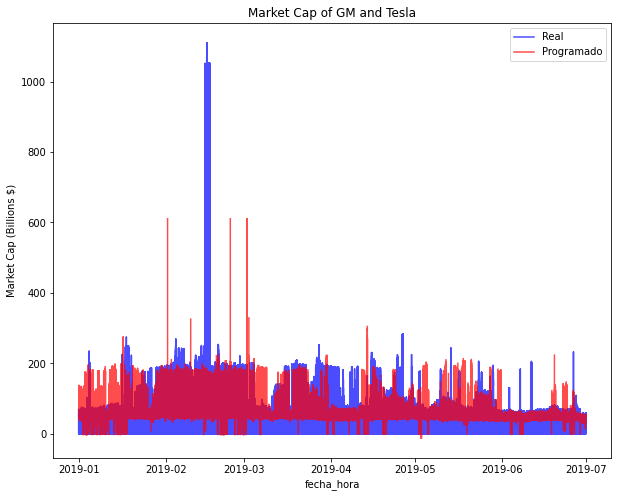

In [33]:
plt.figure(figsize=(10, 8))
plt.plot(costo_marginal['fecha_hora'], costo_marginal['costo_en_dolares'], 'b-', label = 'Real', alpha = 0.7)
plt.plot(costo_marginal['fecha_hora'], costo_marginal['costo_prog'], 'r-', label = 'Programado', alpha = 0.7)
plt.xlabel('fecha_hora'); plt.ylabel('Market Cap (Billions $)'); plt.title('Market Cap of GM and Tesla')
plt.legend();

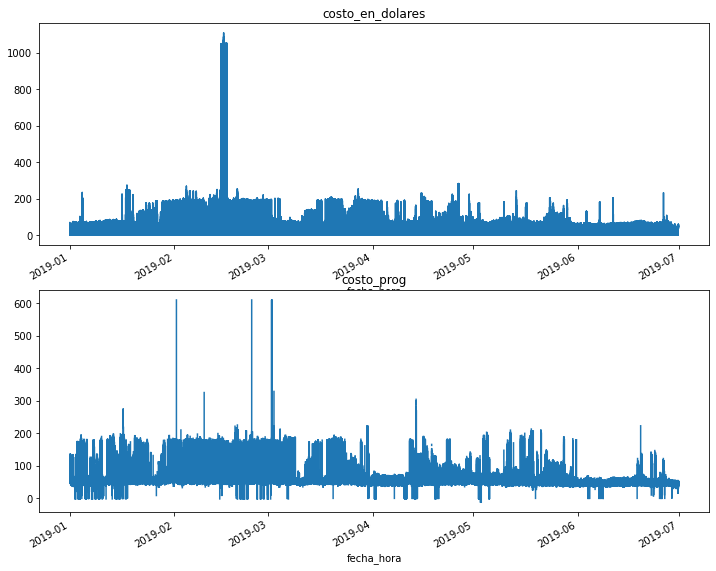

In [34]:
costos_plot = costo_marginal.set_index('fecha_hora')
costos_plot = costos_plot.drop(['costo_en_pesos'], axis = 1)
costos_plot = costos_plot.select_dtypes(include=['float64', 'int64'])
fig,ax = plt.subplots(2,1,figsize=(12,10))
for i,column in enumerate(costos_plot):
    costos_plot[column].plot(ax=ax[i])
    ax[i].set_title(column)

In [35]:
# Tomamos el total de valores unicos de barras en el data frame y calculamos el porcentaje de 
barras_prog = len(costo_marginal[costo_marginal['costo_prog'].notna()]['barra_mnemotecnico'].unique())
barras_tot = len(costo_marginal['barra_mnemotecnico'].unique())

In [36]:
print('El total de barras evaluadas es de', barras_tot)
print('Mientras que el costo se programa para ', barras_prog, 'de ese total')

El total de barras evaluadas es de 1020
Mientras que el costo se programa para  220 de ese total


In [37]:
print('El porcentaje de barras programadas es de un %s %%\n' % round((barras_prog * 100/ barras_tot), 2), 'del total de barras evaluadas')

El porcentaje de barras programadas es de un 21.57 %
 del total de barras evaluadas


Ya que solo el 21.57% del total de barras tiene un costo marginal programado, para la siguientes fases solo consideraremos las barras para las que se les calculó el costo marginal programado, solo así podremos tener una idea de la efectividad y precisión del valor programado.

In [38]:
costo_marginal = costo_marginal.dropna(subset=['barra_mnemotecnico', 'costo_prog'])

In [39]:
costo_marginal.shape

(278870, 5)

In [40]:
len(costo_marginal['barra_mnemotecnico'].unique())

220

### 2. Construcción de variables


- Construye las siguientes variables para la base que creaste en el punto anterior:
    * desviacion: la diferencia entre el costo real y el costo programado
    * desviacion_pct: la misma desviación, pero en porcentaje
    * desviacion_cat: una variable categórica que vale 1si la desviación_pct absoluta es mayor a 15% (esto es, si es menor a -15% o mayor a 15%)
- Describe la variable desviacion_cat . Qué puedes observar? Cambia a través del tiempo?

Al crear la nueva variable 'desviacion_pct' aparecen valores infinitos, que provienen de cuando el costo en dolares de una barra en cierto momento del tiempo es igual a 0, habiendo un costo programado para dicha barra en ese momento. De esta forma, reemplazaremos los valores 0.00 en la variable 'costo_en_dolares' por 0.01. De esta forma evitamos los valores 'inf', mantienendo la interpretabilidad de la desviación entre el costo en dolares y el programado. 

In [41]:
import numpy as np # para sacar valores absolutos

costo_marginal['costo_en_dolares'] = costo_marginal['costo_en_dolares'].replace(0.00, 0.01)

costo_marginal['desviacion'] = costo_marginal['costo_en_dolares'] - costo_marginal['costo_prog']
costo_marginal['desviacion_pct'] = (costo_marginal['desviacion'] / costo_marginal['costo_prog']) * 100
costo_marginal['desviacion_cat'] = 0
costo_marginal.loc[np.abs(costo_marginal['desviacion_pct']) > 15, 'desviacion_cat'] = 1

In [42]:
costo_marginal['desviacion_cat'] = costo_marginal['desviacion_cat'].astype('category')

Al observar el balance de las categorías desvío vs no desvío, vemos que hay un claro desbalance con el cual habrá que lidiar posteriormente para ajustar los modelos de machine learning.

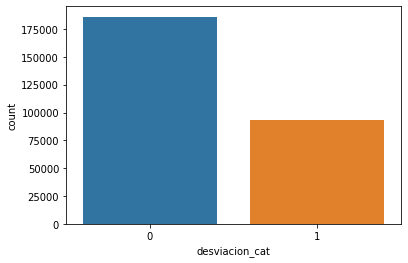

In [43]:
sns.countplot(x="desviacion_cat", data=costo_marginal)

Ahora miraremos la distribución desvíos vs no desvío dependiendo de la hora, el día y el mes, para ver si hay diferencias condicionadas a dichas variables

In [44]:
costo_marginal['month'] = pd.DatetimeIndex(costo_marginal['fecha_hora']).month
costo_marginal['day'] = pd.DatetimeIndex(costo_marginal['fecha_hora']).day
costo_marginal['hour'] = pd.DatetimeIndex(costo_marginal['fecha_hora']).hour

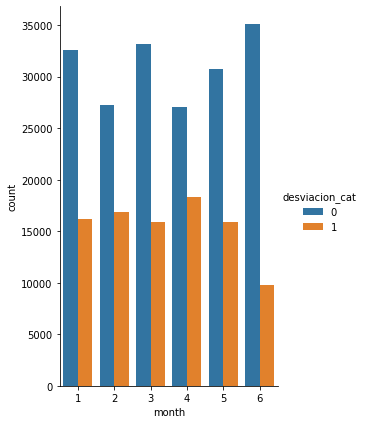

In [45]:
grouped_month = costo_marginal[['month', 'desviacion_cat']].groupby(['month', 'desviacion_cat']).size()
grouped_month = pd.DataFrame(grouped_month)
grouped_month.index.name = 'month'
grouped_month.reset_index(inplace=True)
grouped_month.columns = grouped_month.columns.astype(str)
grouped_month = grouped_month.rename(columns = {'month':'month', 'desviacion_cat':'desviacion_cat', '0':'count'}, inplace = False)
sns.catplot(x="month", y='count',
                hue="desviacion_cat",
                data=grouped_month, kind="bar",
                height=6, aspect=.7)

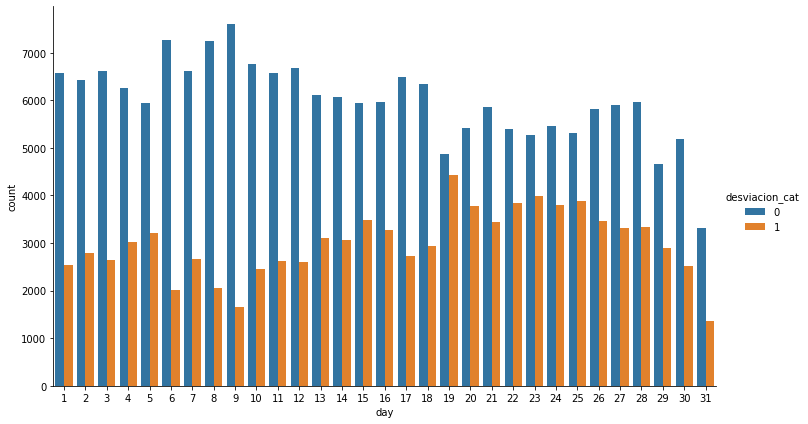

In [46]:
grouped_day = costo_marginal[['day', 'desviacion_cat']].groupby(['day', 'desviacion_cat']).size()
grouped_day = pd.DataFrame(grouped_day)
grouped_day.index.name = 'day'
grouped_day.reset_index(inplace=True)
grouped_day.columns = grouped_day.columns.astype(str)
grouped_day = grouped_day.rename(columns = {'day':'day', 'desviacion_cat':'desviacion_cat', '0':'count'}, inplace = False)
sns.catplot(x="day", y='count',
                hue="desviacion_cat",
                data=grouped_day, kind="bar",
                height=6, aspect=1.7)

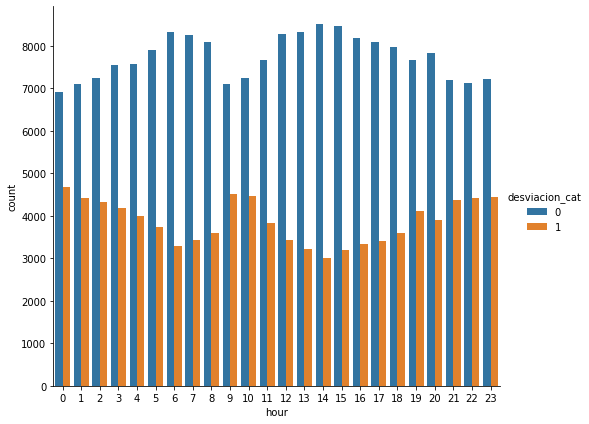

In [47]:
grouped_hour = costo_marginal[['hour', 'desviacion_cat']].groupby(['hour', 'desviacion_cat']).size()
grouped_hour = pd.DataFrame(grouped_hour)
grouped_hour.index.name = 'month'
grouped_hour.reset_index(inplace=True)
grouped_hour.columns = grouped_hour.columns.astype(str)
grouped_hour = grouped_hour.rename(columns = {'hour':'hour', 'desviacion_cat':'desviacion_cat', '0':'count'}, inplace = False)
sns.catplot(x="hour", y='count',
                hue="desviacion_cat",
                data=grouped_hour, kind="bar",
                height=6, aspect=1.2)

Vemos que a través de los meses parece haber una tendencia a la baja de las desviaciones hacia junio. Sin embargo como solo tenemos cada mes una sola vez, no podemos ver si es un patrón que se repita anualmente o no. En cuanto a la variabilidad a través de los días del mes, las barras presentan una proporción menor de desviaciones en la primera quincena que en la segunda. Finalmente, vemos que por horas hay una mayor cantidad de desviaciones en las horas de la noche, entre 21:00 y 02:00 hrs y luego entre las 9:00 y las 10.00 hrs.

### 3. Visualización de datos


- Crea la siguiente función: def time_plot_costo_barra(codigo_barra, fecha_inicial, fecha_final): que tome como input el código de una barra y haga un plot en el tiempo del costo marginal real y del costo marginal programado. El eje x debe ser el tiempo. fecha_inicial y fecha_final_ dan los límites de este plot. Úsa esta función para plotear algunas barras
- Qué puedes concluir de estos plots?
- Además, identifica la barra que tiene cmg_real= 0 durante todos los días y elimínala de tu dataset.

In [48]:
costo_marginal['barra_mnemotecnico'].unique()[0:10]

array(['BA01R003SE013R003', 'BA02R003SE001R003', 'BA01T002SE030T002',
       'BA21L120SE114L120', 'BA01T002SE056T002', 'BA02T005SE081T005',
       'BA69T005SE281T005', 'BA03T002SE014T002', 'BA69L140SE129L140',
       'BA01G004SE035G004'], dtype=object)

In [49]:
from matplotlib import dates
def time_plot_costo_barra(codigo_barra, fecha_inicial, fecha_final):
    df = costo_marginal[(costo_marginal.barra_mnemotecnico == codigo_barra) & (costo_marginal.fecha_hora >= fecha_inicial) & (costo_marginal.fecha_hora <= fecha_final)]
    df_melt = pd.melt(df, id_vars = ['fecha_hora', 'barra_mnemotecnico'], value_vars = ['costo_en_dolares', 'costo_prog'])
    fig, ax = plt.subplots()
    p = sns.lineplot(x="fecha_hora", y="value",
             hue="variable",
             data=df_melt)
    ax.xaxis.set_major_formatter(dates.DateFormatter("%d-%m"))
    plt.xticks(rotation=45)
    return p

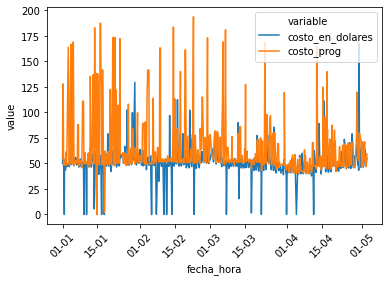

In [50]:
time_plot_costo_barra('BA69L140SE129L140', '2019-01-01', '2019-05-03')

Al plotear varias barras, vemos que las diferencias en el costo real vs el costo programado no es igual en todas. Hay algunas que presentan desviaciones más pequeñas que otras, y algunas que presentan desviaciones con menor frecuencia que otras y en diferentes puntos del tiempo. Así, es posible que la barra sea una factor relevante para predecir la desviación.

Obtenemos la barra con costo real de 0.00 a lo largo del tiempo agrupando los datos por barra, y el que sume 0 en la columna 'costo_en_pesos' es la barra a eliminar (ya que alteramos los valores de costo_en_dolares para evitar los valores infinitos)

In [51]:
costo_marginal.groupby('barra_mnemotecnico', as_index=False).sum().sort_values('costo_en_pesos').iloc[0:3,:]

,barra_mnemotecnico,costo_en_dolares,costo_en_pesos,costo_prog,desviacion,desviacion_pct,month,day,hour
11,BA01G049SE001G049,12.89,0.00000,76354.809150,-76341.919150,-128877.363030,4496,20364,14822
81,BA01T005SE284T005,26295.24,17566.54460,41515.103486,-15219.863486,-23472.607885,1330,10347,7616
171,BA36T027SE067G216,31909.57,21312.01963,39753.716171,-7844.146170,-8573.964111,1257,9632,7308


In [52]:
costo_marginal = costo_marginal[costo_marginal.barra_mnemotecnico != 'BA01G049SE001G049']

### 4. Base para los modelos


- Carga la base base_para_predicción.csv. Esta será la base principal para las siguientes preguntas.
- En rasgos generales, ¿Qué puedes decir de los datos? (dimensiones, tipo de datos, variables categóricas, variables numéricas, fechas).
- A partir de la variable fecha, crea nuevas variables para el año, mes, semana del año, dia del calendario, dia de la semana y una variable que indique si el dia corresponde a un día de semana o fin de semana. Estas features/variables te servirán para entrenar el modelo.
- Implementa una función que para una subestación y una variable, grafique múltiples series de tiempo diarias correspondientes a una lista de fechas. Para esto, la función debe recibir como argumentos: código de una subestación, una variable (serie numérica), y una lista de fechas (año-mes-día). Por ejemplo: para la subestación SE005T002 y la variable gen_solar_total_mwh, la función debe graficar los perfiles diarios de generación solar por hora para las fechas '2019-01-10', '2019-02-10' y '2019-03-10'.
- Grafica la curva de generación solar, por hora, en la subestación SE005T002 para las fechas del 10, 11, 12, 13 y 14 de enero de 2019. Haz lo mismo para la subestación SE127T005. Que podrías decir, en términos generales, sobre la generación solar y las dos subestaciones mencionadas, basados en estos dos gráficos?
- Grafica la curva de generación térmica, por hora, en la subestación SE020G213 para los días 14, 15, 16 y 17 de mayo de 2019. Haz lo mismo para la subestación SE106G216. Que podrías decir, en términos generales, sobre la generación térmica en esta subestación con respecto a este gráfico?

In [53]:
df_pred = pd.read_csv("data/base_para_prediccion.csv")

In [54]:
df_pred.head()

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
0,SE031G216,2019-01-04 00:00:00 UTC,1,NaN,NaN,NaN,NaN,0.0,56.2,55.627852,0.57,1.02,2,1210767,13.20785
1,SE031G216,2019-01-04 00:00:00 UTC,2,NaN,NaN,NaN,NaN,0.0,56.2,55.376645,0.82,1.48,2,113232,13.20785
2,SE031G216,2019-01-04 00:00:00 UTC,3,NaN,NaN,NaN,NaN,0.0,56.2,59.531891,-3.33,-5.59,2,1089415,13.20785
3,SE031G216,2019-01-04 00:00:00 UTC,4,NaN,NaN,NaN,NaN,0.0,56.2,174.378923,-118.18,-67.77,2,1096867,13.20785
4,SE031G216,2019-01-04 00:00:00 UTC,5,NaN,NaN,NaN,NaN,0.0,56.2,172.820310,-116.62,-67.48,2,1071851,13.20785


In [55]:
df_pred.shape

(112779, 15)

In [56]:
df_pred.dtypes

nemotecnico_se               object
fecha                        object
hora                          int64
gen_eolica_total_mwh        float64
gen_geotermica_total_mwh    float64
gen_hidraulica_total_mwh    float64
gen_solar_total_mwh         float64
gen_termica_total_mwh       float64
cmg_real                    float64
cmg_prog                    float64
cmg_desv                    float64
cmg_desv_pct                float64
n_barras                      int64
demanda_mwh                   int64
cap_inst_mw                 float64
dtype: object

In [57]:
df_pred.describe()

,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,cmg_desv,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw
count,112779.000000,0.0,0.0,34184.000000,41818.000000,61863.000000,112779.000000,112779.000000,112779.000000,112779.00,112779.000000,1.127790e+05,112779.000000
mean,12.502993,NaN,NaN,38.120053,3.764987,40.583146,61.170058,62.215400,-1.045338,inf,2.331844,6.357056e+07,128.719565
std,6.924090,NaN,NaN,69.838109,12.904388,101.083396,25.414147,25.307759,24.711575,NaN,1.304096,3.948683e+08,167.948649
min,1.000000,NaN,NaN,0.000000,0.000000,0.000000,0.000000,-1.713131,-562.470000,-3403.97,1.000000,-9.821095e+09,2.989800
25%,7.000000,NaN,NaN,0.849787,0.000000,0.000000,49.130000,49.906745,-3.790000,-7.07,1.000000,7.464800e+05,18.420000
50%,13.000000,NaN,NaN,9.600000,0.000000,0.000000,54.610000,55.420601,-0.310000,-0.58,2.000000,4.507282e+06,51.850000
75%,19.000000,NaN,NaN,40.000000,1.571022,15.960000,63.500000,64.701951,1.670000,2.92,3.000000,1.332345e+07,184.685500
max,25.000000,NaN,NaN,472.000000,86.050000,570.600800,240.360000,610.600000,175.020000,inf,6.000000,1.004240e+10,597.782800


Por lo que se puede observar de los datos en este punto, el archivo contiene 15 variables incluyendo la variable identificadora y 112.779 filas. Todas las variables menos 'nemotecnico_se' y 'fecha' son numéricas. La variable 'fecha' está reconocida como caracter, no como serie de tiempo, por lo cual es posible que debamos modificarla.
La hora nuevamente va de 1 25, por lo que habría que modificarla. También la hora de la variable 'fecha' no coincide con la variable 'hora' por lo que al parecer se formateó erróneamente desde los datos originales.
Finalmente, 'gen_eolica_total_mwh' y 'gen_geotermica_total_mwh' tienen solo valores nulos, por lo que son variables que podrían eliminarse.

In [58]:
type(df_pred['fecha'])

pandas.core.series.Series

In [59]:
df_pred['mes'] = pd.DatetimeIndex(df_pred['fecha']).month
df_pred['dia_mes'] = pd.DatetimeIndex(df_pred['fecha']).day
df_pred['anio'] = pd.DatetimeIndex(df_pred['fecha']).year
df_pred['dia_semana'] = pd.DatetimeIndex(df_pred['fecha']).weekday
df_pred['semana_anio'] = pd.DatetimeIndex(df_pred['fecha']).strftime('%V')
df_pred['findesemana'] = np.where((df_pred['dia_semana']) == 6 | (df_pred['dia_semana'] == 5), 1, 0)

In [60]:
df_pred.shape

(112779, 21)

In [61]:
df_pred['fecha'] = df_pred['fecha'].str.replace(' UTC', '')
df_pred.loc[:,'fecha'] = pd.to_datetime(df_pred['fecha'])

In [62]:
df_pred.head()

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,...,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,mes,dia_mes,anio,dia_semana,semana_anio,findesemana
0,SE031G216,2019-01-04,1,NaN,NaN,NaN,NaN,0.0,56.2,55.627852,...,1.02,2,1210767,13.20785,1,4,2019,4,01,0
1,SE031G216,2019-01-04,2,NaN,NaN,NaN,NaN,0.0,56.2,55.376645,...,1.48,2,113232,13.20785,1,4,2019,4,01,0
2,SE031G216,2019-01-04,3,NaN,NaN,NaN,NaN,0.0,56.2,59.531891,...,-5.59,2,1089415,13.20785,1,4,2019,4,01,0
3,SE031G216,2019-01-04,4,NaN,NaN,NaN,NaN,0.0,56.2,174.378923,...,-67.77,2,1096867,13.20785,1,4,2019,4,01,0
4,SE031G216,2019-01-04,5,NaN,NaN,NaN,NaN,0.0,56.2,172.820310,...,-67.48,2,1071851,13.20785,1,4,2019,4,01,0


In [63]:
lista_fechas = ['2019-01-10', '2019-01-11', '2019-01-12', '2019-01-13', '2019-01-14']
df_pred[df_pred.fecha.isin(lista_fechas)]

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,...,cmg_desv_pct,n_barras,demanda_mwh,cap_inst_mw,mes,dia_mes,anio,dia_semana,semana_anio,findesemana
327,SE001T002,2019-01-10,1,NaN,NaN,NaN,0.0,0.000,50.73,52.504364,...,-3.37,2,115100027,14.2881,1,10,2019,3,02,0
328,SE001T002,2019-01-10,2,NaN,NaN,NaN,0.0,0.000,50.73,52.017483,...,-2.48,2,133530877,14.2881,1,10,2019,3,02,0
329,SE001T002,2019-01-10,3,NaN,NaN,NaN,0.0,0.000,50.73,52.032915,...,-2.50,2,128296057,14.2881,1,10,2019,3,02,0
330,SE001T002,2019-01-10,4,NaN,NaN,NaN,0.0,0.000,50.73,52.032915,...,-2.50,2,121300013,14.2881,1,10,2019,3,02,0
331,SE001T002,2019-01-10,5,NaN,NaN,NaN,0.0,0.000,50.73,169.894814,...,-70.14,2,121705219,14.2881,1,10,2019,3,02,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
108765,SE170T005,2019-01-14,20,NaN,NaN,NaN,NaN,1.800,50.33,52.805214,...,-4.70,3,655088,30.1400,1,14,2019,0,03,0
108766,SE170T005,2019-01-14,21,NaN,NaN,NaN,NaN,1.425,50.33,52.812324,...,-4.70,3,8346504,30.1400,1,14,2019,0,03,0
108767,SE170T005,2019-01-14,22,NaN,NaN,NaN,NaN,1.525,50.33,52.807554,...,-4.70,3,9169738,30.1400,1,14,2019,0,03,0
108768,SE170T005,2019-01-14,23,NaN,NaN,NaN,NaN,1.475,48.65,52.807554,...,-7.88,3,9323187,30.1400,1,14,2019,0,03,0


In [64]:
def time_dist(codigo_se, var_num, lista_fechas):
    df = df_pred[df_pred.fecha.isin(lista_fechas)]
    fig, ax = plt.subplots()
    p = sns.lineplot(x='fecha', y=var_num,
             data=df[(df.nemotecnico_se == codigo_se)])
    ax.xaxis.set_major_formatter(dates.DateFormatter("%m-%d"))
    plt.xticks(rotation=45)
    return p

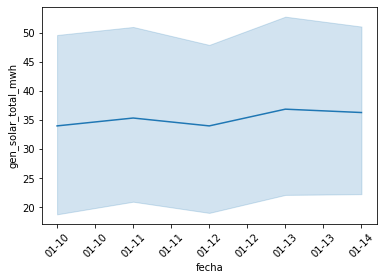

In [65]:
time_dist('SE005T002', 'gen_solar_total_mwh', ['2019-01-10', '2019-01-11', '2019-01-12', '2019-01-13', '2019-01-14'])

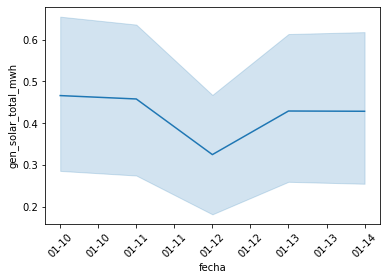

In [66]:
time_dist('SE127T005', 'gen_solar_total_mwh', ['2019-01-10', '2019-01-11', '2019-01-12', '2019-01-13', '2019-01-14'])

En ambas barras se ve que la generación de energía solar tiene una curva similar, pero es más pronunciada en la segunda barra, donde hay una disminución importante el día 12 de enero, pero en ambos casos la tendencia a disminución comienza el día 11 de enero y se recupera el día 13. Puede tener que ver con el clima en ese día, siendo enero verano, puede que la disminución de generación de energía solar en distintos niveles se asocie a la ubicación de las subestaciones analizadas. Esto se podría rastrear teniendo la ubicación de cada subestación y el clima en ese rango de fechas. Otra observación es que la generación solar en el primer caso es mucho mayor que en el segundo, mirando el eje y.

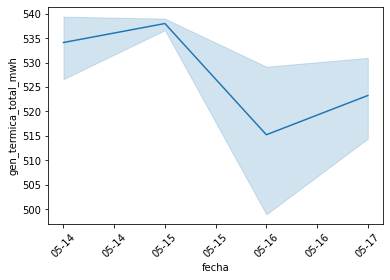

In [67]:
time_dist('SE020G213', 'gen_termica_total_mwh', ['2019-05-14', '2019-05-15', '2019-05-16', '2019-05-17'])

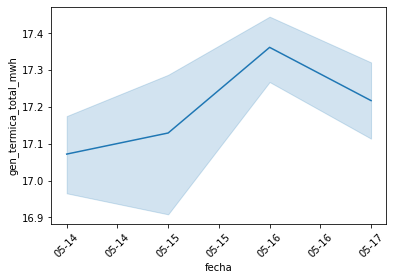

In [68]:
time_dist('SE106G216', 'gen_termica_total_mwh', ['2019-05-14', '2019-05-15', '2019-05-16', '2019-05-17'])

Se observa que el peak de la segunda subestación calza con el punto más bajo de la primera. El primer caso tiene una generación térmica total mucho más alta que el segundo caso, lo cual se deduce observando el rango del eje y. Así, la baja es mucho más importante el día 16 en el caso 1 que el alza que se produce en el segundo caso el mismo día. De esta manera, aunque aparentemente tengan un comportamiento diferente, puede que ajustados a la misma escala la variación hacia el alza en el segundo caso sea apenas perceptible, siendo la baja un patrón de todas formas específico del primer caso.

### 5. Predicción de desviaciones del costo marginal: modelo 1


- Crea una variable target que sea igual a cero cuando la variable cmg_desv_pct esté en el rango [-15,15], e igual uno para cualquier otro caso. Hint: recuerda que existen valores infinitos.
- Ahora crea los siguientes features:
    - en_total_mwh: suma de las cinco series de generación.
    - lags y estadísticas acumuladas (por ejemplo: promedio, varianza) de las variables que consideres relevantes.
- Entrena un modelo que prediga si existirá una desviación en la hora siguiente. Adecúa la variable target para hacer esto posible.
- ¿Cómo le va a tu modelo? ¿En qué métricas te basas y por qué?
- ¿Cuales son las variables más importantes que considera este modelo?

Reemplazamos los valores infinitos de la columna 'cmg_desv_pct' por un '100' ya que en estos casos el valor real es un 100% menos que el valor programado.

In [69]:
df_pred['en_total_mwh'] = df_pred[['gen_eolica_total_mwh', 'gen_geotermica_total_mwh', 'gen_hidraulica_total_mwh', 'gen_solar_total_mwh', 'gen_termica_total_mwh']].sum(axis=1)
df_pred['cmg_desv_pct'] = df_pred['cmg_desv_pct'].replace([np.inf], 100)

df_pred['cmg_desv_cat'] = 0
df_pred.loc[np.abs(df_pred['cmg_desv_pct']) > 15, 'cmg_desv_cat'] = 1

In [70]:
df_pred.shape

(112779, 23)

In [71]:
df_pred.sort_values('fecha')

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,...,demanda_mwh,cap_inst_mw,mes,dia_mes,anio,dia_semana,semana_anio,findesemana,en_total_mwh,cmg_desv_cat
99683,SE106G216,2019-01-01,17,NaN,NaN,NaN,NaN,15.42,0.000000,46.151229,...,4283907,18.4200,1,1,2019,1,01,1,15.420000,1
88642,SE081T005,2019-01-01,14,NaN,NaN,NaN,0.836306,0.00,48.120000,42.840158,...,4823603,11.9950,1,1,2019,1,01,1,0.836306,0
88641,SE081T005,2019-01-01,13,NaN,NaN,NaN,3.064950,0.00,48.150000,44.090868,...,8263271,11.9950,1,1,2019,1,01,1,3.064950,0
88640,SE081T005,2019-01-01,12,NaN,NaN,NaN,3.067111,0.00,48.150000,44.670536,...,8230299,11.9950,1,1,2019,1,01,1,3.067111,0
88639,SE081T005,2019-01-01,11,NaN,NaN,NaN,3.069758,0.00,48.150000,45.629092,...,7782978,11.9950,1,1,2019,1,01,1,3.069758,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
47772,SE014T002,2019-06-30,4,NaN,NaN,NaN,0.000000,0.00,37.795000,37.936034,...,71222806,83.4631,6,30,2019,6,26,0,0.000000,0
47771,SE014T002,2019-06-30,3,NaN,NaN,NaN,0.000000,0.00,38.035000,38.269629,...,76980171,83.4631,6,30,2019,6,26,0,0.000000,0
47770,SE014T002,2019-06-30,2,NaN,NaN,NaN,0.000000,0.00,38.035000,38.671572,...,76290951,83.4631,6,30,2019,6,26,0,0.000000,0
43569,SE009T002,2019-06-30,24,NaN,NaN,NaN,NaN,0.00,46.843333,42.412289,...,1118279,153.8800,6,30,2019,6,26,0,0.000000,0


In [72]:
#df_pred2 = df_pred.drop('nemotecnico_se', axis = 1)
df_pred2 = df_pred.set_index('fecha')

Rellenamos NA's con valores 0. Debería evaluarse estudiando mejor el caso cuál podría ser un tratamiento alternativo de los NA.

In [73]:
df_pred2['semana_anio'] = df_pred['semana_anio'].astype('int64')
df_pred2.fillna(0, inplace=True)
df_pred2.dtypes

nemotecnico_se               object
hora                          int64
gen_eolica_total_mwh        float64
gen_geotermica_total_mwh    float64
gen_hidraulica_total_mwh    float64
gen_solar_total_mwh         float64
gen_termica_total_mwh       float64
cmg_real                    float64
cmg_prog                    float64
cmg_desv                    float64
cmg_desv_pct                float64
n_barras                      int64
demanda_mwh                   int64
cap_inst_mw                 float64
mes                           int64
dia_mes                       int64
anio                          int64
dia_semana                    int64
semana_anio                 float64
findesemana                   int64
en_total_mwh                float64
cmg_desv_cat                  int64
dtype: object

Ahora quitaré las variables que se utilizaron para construir la variable target, de lo contrario sería muy similar a predecir la variable target consigo misma. Quitaremos las variables 'cmg_desv_pct', 'cmg_desv' y 'cmg_prog'.

In [74]:
df_pred2 = df_pred2.drop(['cmg_desv_pct', 'cmg_desv', 'cmg_prog', 'nemotecnico_se'], axis = 1)

In [75]:
df_pred2.shape

(112779, 18)

In [76]:
df_pred2.iloc[:,17:18]

,cmg_desv_cat
fecha,
2019-01-04,0
2019-01-04,0
2019-01-04,0
2019-01-04,1
2019-01-04,1
...,...
2019-06-30,0
2019-06-30,0
2019-06-30,0


In [77]:
from sklearn.preprocessing import LabelEncoder
values = df_pred2.values
encoder = LabelEncoder()

values[:,17] = encoder.fit_transform(values[:,17])
values[:,17]

array([0., 0., 0., ..., 0., 0., 1.])

In [78]:
df_pred2.head()

,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,n_barras,demanda_mwh,cap_inst_mw,mes,dia_mes,anio,dia_semana,semana_anio,findesemana,en_total_mwh,cmg_desv_cat
fecha,,,,,,,,,,,,,,,,,,
2019-01-04,1,0.0,0.0,0.0,0.0,0.0,56.2,2,1210767,13.20785,1,4,2019,4,0.0,0,0.0,0
2019-01-04,2,0.0,0.0,0.0,0.0,0.0,56.2,2,113232,13.20785,1,4,2019,4,0.0,0,0.0,0
2019-01-04,3,0.0,0.0,0.0,0.0,0.0,56.2,2,1089415,13.20785,1,4,2019,4,0.0,0,0.0,0
2019-01-04,4,0.0,0.0,0.0,0.0,0.0,56.2,2,1096867,13.20785,1,4,2019,4,0.0,0,0.0,1
2019-01-04,5,0.0,0.0,0.0,0.0,0.0,56.2,2,1071851,13.20785,1,4,2019,4,0.0,0,0.0,1


A continuación se comprueba el desbalance de las categorías, por lo que se hará un oversampling más adelante.

In [79]:
# se deduce de aquí que hay un desbalance favorable a los ceros, es decir hacia los no fugados
df_pred2['cmg_desv_cat'].astype('category').value_counts()

0    84288
1    28491
Name: cmg_desv_cat, dtype: int64

#### Random Forest

Entrenaremos un modelo de Random Forest que prediga si existirá una desviación en la hora siguiente. Para ello tomaremos las variables evaluadas en la hora anterior para predecir la hora siguiente. De esta forma se usará 1 lag para transformar las variables.
Se recomienda al equipo consultor realizar las correcciones pertinentes a la data para corregir problemas asociados a la dependencia que podría existir en las variables independientes, ya que los modelos de Random Forest asumen independencia entre estos. 

In [80]:
# Esta función fue extraída de https://www.kaggle.com/lokeshkumarn/timeseries-multivariate
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # secuencia input (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # secuencia para el forecast (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # unir todo
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # Botar NA's, aunque ya las rellenamos con 0's asi es que este paso se debería poder omitir
    if dropnan:
        agg.dropna(inplace=True)
    return agg

Creamos los lags y ajustamos la data para solo contabilizar las variables medidas en la hora previa. Anteriormente vimos que la subestación podría ayudar a predecir si habrá un desvío o no, así es que mantendremos la presencia de esta variable. 

In [81]:
supervised = series_to_supervised(values,1,1)

supervised.drop(supervised.columns[[18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34]], axis=1, inplace=True)
supervised.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var14(t-1),var15(t-1),var16(t-1),var17(t-1),var18(t-1),var18(t)
1,1.0,0.0,0.0,0.0,0.0,0.0,56.2,2.0,1210767.0,13.20785,1.0,4.0,2019.0,4.0,0.0,0.0,0.0,0.0,0.0
2,2.0,0.0,0.0,0.0,0.0,0.0,56.2,2.0,113232.0,13.20785,1.0,4.0,2019.0,4.0,0.0,0.0,0.0,0.0,0.0
3,3.0,0.0,0.0,0.0,0.0,0.0,56.2,2.0,1089415.0,13.20785,1.0,4.0,2019.0,4.0,0.0,0.0,0.0,0.0,1.0
4,4.0,0.0,0.0,0.0,0.0,0.0,56.2,2.0,1096867.0,13.20785,1.0,4.0,2019.0,4.0,0.0,0.0,0.0,1.0,1.0
5,5.0,0.0,0.0,0.0,0.0,0.0,56.2,2.0,1071851.0,13.20785,1.0,4.0,2019.0,4.0,0.0,0.0,0.0,1.0,1.0


In [82]:
pd.DataFrame(supervised).shape

(112778, 19)

In [83]:
supervised.columns

Index(['var1(t-1)', 'var2(t-1)', 'var3(t-1)', 'var4(t-1)', 'var5(t-1)',
       'var6(t-1)', 'var7(t-1)', 'var8(t-1)', 'var9(t-1)', 'var10(t-1)',
       'var11(t-1)', 'var12(t-1)', 'var13(t-1)', 'var14(t-1)', 'var15(t-1)',
       'var16(t-1)', 'var17(t-1)', 'var18(t-1)', 'var18(t)'],
      dtype='object')

In [84]:
supervised.head().iloc[:,[18]]

,var18(t)
1,0.0
2,0.0
3,1.0
4,1.0
5,1.0


In [85]:
X = supervised.iloc[:,0:18].values
y = supervised.iloc[:, 18].values

from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [86]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Como detectamos anteriormente un desbalance en los desvíos vs no desvíos, a continuación se realiza un oversampling. También deberemos dar

In [87]:
from imblearn.over_sampling import SMOTE
sm = SMOTE(random_state = 123) 

X_train, y_train = sm.fit_resample(X_train, y_train)

In [88]:
temp = pd.DataFrame(y_train)
temp.iloc[:,0].astype('category').value_counts()

1.0    67416
0.0    67416
Name: 0, dtype: int64

In [89]:
# importar RF
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(criterion = 'entropy')

In [90]:
rf_model1 = rf.fit(X_train, y_train)
preds_rf_test = rf_model1.predict(X_test)
preds_rf_train = rf_model1.predict(X_train)

In [91]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(confusion_matrix(y_test,preds_rf_test))
print(classification_report(y_test,preds_rf_test))
print(accuracy_score(y_test, preds_rf_test))

print(confusion_matrix(y_train,preds_rf_train))
print(classification_report(y_train,preds_rf_train))
print(accuracy_score(y_train,preds_rf_train))

[[15802  1069]
 [ 1251  4434]]
              precision    recall  f1-score   support

         0.0       0.93      0.94      0.93     16871
         1.0       0.81      0.78      0.79      5685

    accuracy                           0.90     22556
   macro avg       0.87      0.86      0.86     22556
weighted avg       0.90      0.90      0.90     22556

0.8971448838446533
[[67416     0]
 [    1 67415]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     67416
         1.0       1.00      1.00      1.00     67416

    accuracy                           1.00    134832
   macro avg       1.00      1.00      1.00    134832
weighted avg       1.00      1.00      1.00    134832

0.9999925833629999


Vemos que al modelo le va relativamente bien, tiene un alto accuracy en el dataset de testeo, lo cual indica que en términos generales el modelo logra predecir las categorías. Sin embargo, al obsevar el recall, la precisión y el f1-score, vemos que el modelo logra predecir mejor la categoría no desvío que la categoría desvío. Sería importante estudiar con la contraparte la ponderación de las consecuencias de tener una mayor tasa de falsos positivos o de falsos negativos. En este caso en particular, sugeriría estudiar las consecuencias de los desvíos positivos vs los desvíos negativos en la eficiencia distributiva de la energía, y también en los costos. Puede que sea una variable relevante.

En definitiva, el modelo funciona relativamente bien, pero deberían destinarse esfuerzos a mejorar el recall y con ello el f1-score específicamente. Además, hay un sobreajuste evidente del modelo, el cual también debería intentar mejorarse

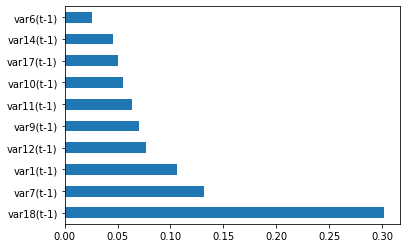

In [92]:
feat_importances = pd.Series(rf_model1.feature_importances_, index=supervised.iloc[:,0:18].columns)
feat_importances.nlargest(10).plot(kind='barh')

La variable más importante es si durante la hora previa hubo o no un desvío en el costo programado ('var18(t-1)'), es la variable que entrega mayor capacidad predictiva al modelo. Luego el costo real obtenido en la hora previa ('var7(t-1)'), y la hora, en la hora previa ('var1(t-1)'), también destacan como variables que más aportan al modelo. Luego vendrían el día del mes de la observación durante la hora previa ('var12(t-1)'), la demanda ('var9(t-1)') durante la hora previa, el mes de la observación en la hora previa ('var11(t-1)'), la capacidad de generación máxima instalada presente en la observación de la hora previa ('var10(t-1)'), la suma de generación de los diferentes tipos de energía en la observación de la hora previa ('var17(t-1)'), el día de la semana (de lunes a viernes) de la observación de la hora previa, y la generación de energía hidráulica de la hora previa.

### 6. Predicción de desviaciones del costo marginal: modelo 2


- Ahora imagina que te dicen que, en producción, te enviarán datos actualizados del sistema cada 12 horas. ¿Cuál debiese ser tu target a predecir en ese caso? Explica.
- Entrena un nuevo modelo con ese target y evalúalo con una métrica que te parezca importante. ¿Cómo se compara con los resultados del modelo 1?

En este caso la variable target debiera ser si hay o no desvío en la próxima hora, pero considerando el valor que tuvieron las variables independientes doce horas antes. Así, una llegados los datos, puedo predecir si habrá o no un desvío en la hora siguiente utilizando los datos de 12 horas antes.

In [93]:
supervised2 = series_to_supervised(values,12,1)

supervised2 = supervised2.loc[:,['var18(t-12)',
                               'var17(t-12)','var16(t-12)','var15(t-12)','var14(t-12)',
                               'var13(t-12)','var12(t-12)', 'var11(t-12)','var10(t-12)',
                               'var9(t-12)','var8(t-12)','var7(t-12)','var6(t-12)',
                               'var5(t-12)','var4(t-12)','var3(t-12)','var2(t-12)',
                               'var1(t-12)', 'var18(t)']]


In [94]:
supervised2.shape

(112767, 19)

In [95]:
X = supervised2.iloc[:, 0:18].values
X = scaler.fit_transform(X)

y = supervised2.iloc[:, 18].values

In [96]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Nuevamente nos hacemos cargo del desbalance de categorías de la variable dependiente

In [97]:
X_train, y_train = sm.fit_resample(X_train, y_train)

In [98]:
rf_model2 = rf.fit(X_train, y_train)
preds_rf_test = rf_model2.predict(X_test)
preds_rf_train = rf_model2.predict(X_train)

In [99]:
print(confusion_matrix(y_test,preds_rf_test))
print(classification_report(y_test,preds_rf_test))
print(accuracy_score(y_test, preds_rf_test))

print(confusion_matrix(y_train,preds_rf_train))
print(classification_report(y_train,preds_rf_train))
print(accuracy_score(y_train,preds_rf_train))

[[15818  1091]
 [ 1445  4200]]
              precision    recall  f1-score   support

         0.0       0.92      0.94      0.93     16909
         1.0       0.79      0.74      0.77      5645

    accuracy                           0.89     22554
   macro avg       0.86      0.84      0.85     22554
weighted avg       0.89      0.89      0.89     22554

0.8875587478939434
[[67373     0]
 [    0 67373]]
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     67373
         1.0       1.00      1.00      1.00     67373

    accuracy                           1.00    134746
   macro avg       1.00      1.00      1.00    134746
weighted avg       1.00      1.00      1.00    134746

1.0


El modelo está claramente sobreajustado, por la diferencia entre los indicadores obtenidos en los datos de entrenamiento vs los de testeo. Sin embargo, el modelo mantiene relativamente buen desempeño en los datos de testeo, aunque igual que en el modelo 1, se deberían destinar esfuerzos a mejorar la precisión y el recall, y con ello el f1-score para la categoría desvío, ya que son los que indican si hay una buena capacidad de predicción para esa categoría de la variable dependiente.

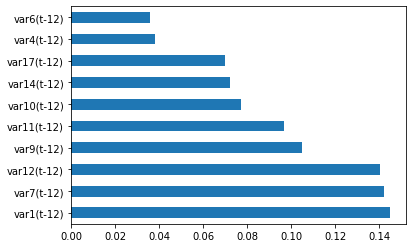

In [100]:
feat_importances = pd.Series(rf_model2.feature_importances_, index=supervised2.iloc[:,0:18].columns)
feat_importances.nlargest(10).plot(kind='barh')

La variable más importante es si durante la hora previa hubo o no un desvío en el costo programado ('var18(t-12)'), luego el el costo real obtenido en las 12 horas previas ('var7(t-12)'), luego el día del mes de la observación durante las 12 horas anteriores a la hora de predicción ('var12(t-12)'), luego la demanda ('var9(t-1)') durante las 12 horas previas y el mes de la observación en la hora previa ('var11(t-12)'). Finalmente, con menor importancia pero igual aportando al modelo se encuentran las variables de la capacidad de generación máxima instalada presente en la observación de las 12 horas previas ('var10(t-12)'),  el día de la semana (de lunes a viernes) de la observación de las 12 horas previas ('var14(t-12)'), la suma de generación de los diferentes tipos de energía en la observación de las 12 horas previas ('var17(t-12)'), la generación de energía hidráulica de las 12 horas previas ('var4(t-12)') y la generación de energía térmica de las 12 horas previas ('var6(t-12)').

### 7. Merge con datos de clima: modelo 3


- Haz un merge con los datos de clima (datos_clima.csv) y entrena nuevamente tu modelo 2.
- ¿Cómo manejas el data leakage en este caso? ¿Cuánto mejora la capacidad predictiva del modelo? ¿Cuáles variables son las más importantes?

In [101]:
clima = pd.read_csv('data/datos_clima.csv')

In [102]:
clima['fecha'] = clima['fecha'].str.replace(' UTC', '')
clima.loc[:,'fecha'] = pd.to_datetime(clima['fecha'], utc = True)
df_pred.loc[:,'fecha'] = pd.to_datetime(df_pred['fecha'], utc = True)

In [103]:
df_pred_clima = df_pred.merge(clima, how = "left", left_on=['nemotecnico_se', 'fecha'], right_on=['subestacion', 'fecha'])

In [104]:
cmg_alone = df_pred_clima[['cmg_desv_cat']]
df_pred_clima = df_pred_clima.drop('cmg_desv_cat', axis = 1)
df_pred_clima['cmg_desv_cat'] = cmg_alone
                                   
df_pred_clima.shape                                   

(112779, 42)

In [105]:
df_pred_clima.head()

,nemotecnico_se,fecha,hora,gen_eolica_total_mwh,gen_geotermica_total_mwh,gen_hidraulica_total_mwh,gen_solar_total_mwh,gen_termica_total_mwh,cmg_real,cmg_prog,...,T2M_MIN,TQV,TS,WS10M,WS10M_MAX,WS10M_MIN,WS50M,WS50M_MAX,WS50M_MIN,cmg_desv_cat
0,SE031G216,2019-01-04 00:00:00+00:00,1,NaN,NaN,NaN,NaN,0.0,56.2,55.627852,...,17.16,3.33,23.89,3.56,6.31,1.5,3.4,5.49,1.47,0
1,SE031G216,2019-01-04 00:00:00+00:00,2,NaN,NaN,NaN,NaN,0.0,56.2,55.376645,...,17.16,3.33,23.89,3.56,6.31,1.5,3.4,5.49,1.47,0
2,SE031G216,2019-01-04 00:00:00+00:00,3,NaN,NaN,NaN,NaN,0.0,56.2,59.531891,...,17.16,3.33,23.89,3.56,6.31,1.5,3.4,5.49,1.47,0
3,SE031G216,2019-01-04 00:00:00+00:00,4,NaN,NaN,NaN,NaN,0.0,56.2,174.378923,...,17.16,3.33,23.89,3.56,6.31,1.5,3.4,5.49,1.47,1
4,SE031G216,2019-01-04 00:00:00+00:00,5,NaN,NaN,NaN,NaN,0.0,56.2,172.820310,...,17.16,3.33,23.89,3.56,6.31,1.5,3.4,5.49,1.47,1


Rellenamos NA's con valores 0. Como se mencionó antes, debería evaluarse estudiando mejor el caso cuál podría ser un tratamiento alternativo de los NA.

In [106]:
df_pred_clima = df_pred_clima.drop(['nemotecnico_se', 'subestacion', 'cmg_desv_pct', 'cmg_desv', 'cmg_prog'], axis = 1)
df_pred_clima = df_pred_clima.set_index('fecha')
df_pred_clima.fillna(0, inplace=True)

In [142]:
df_pred_clima.head().iloc[:,19:30]

,ALLSKY_SFC_SW_DWN,KT,PRECTOT,RH2M,T2M,T2MDEW,T2M_MAX,T2M_MIN,TQV,TS,WS10M
fecha,,,,,,,,,,,
2019-01-04 00:00:00+00:00,6.95,0.6,0.08,67.97,20.55,14.53,25.07,17.16,3.33,23.89,3.56
2019-01-04 00:00:00+00:00,6.95,0.6,0.08,67.97,20.55,14.53,25.07,17.16,3.33,23.89,3.56
2019-01-04 00:00:00+00:00,6.95,0.6,0.08,67.97,20.55,14.53,25.07,17.16,3.33,23.89,3.56
2019-01-04 00:00:00+00:00,6.95,0.6,0.08,67.97,20.55,14.53,25.07,17.16,3.33,23.89,3.56
2019-01-04 00:00:00+00:00,6.95,0.6,0.08,67.97,20.55,14.53,25.07,17.16,3.33,23.89,3.56


In [108]:
values = df_pred_clima.values

In [112]:
supervised3 = series_to_supervised(values,12,1)

supervised3 = supervised3.loc[:,['var36(t-12)',
                                 'var35(t-12)','var34(t-12)','var33(t-12)', 'var32(t-12)',
                                 'var31(t-12)','var30(t-12)','var29(t-12)', 'var28(t-12)',
                                 'var27(t-12)','var26(t-12)','var25(t-12)', 'var24(t-12)',
                                 'var23(t-12)','var22(t-12)','var21(t-12)', 'var20(t-12)',
                                 'var19(t-12)', 'var18(t-12)',
                               'var17(t-12)','var16(t-12)','var15(t-12)','var14(t-12)',
                               'var13(t-12)','var12(t-12)', 'var11(t-12)','var10(t-12)',
                               'var9(t-12)','var8(t-12)','var7(t-12)','var6(t-12)',
                               'var5(t-12)','var4(t-12)','var3(t-12)','var2(t-12)', 'var36(t)']]

In [115]:
supervised3.shape

(112767, 36)

In [120]:
X = supervised3.iloc[:, 0:35].values

X = scaler.fit_transform(X)

y = supervised3.iloc[:, 35].values
y = y.astype('int')

In [121]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Nuevamente nos hacemos cargo del desbalance de categorías de la variable dependiente, ya que al tener que calcular los lags de las variables nuevamente al hacer el merge, el oversampling realizado en un comienzo se perdió.

In [122]:
X_train, y_train = sm.fit_resample(X_train, y_train)

In [123]:
rf_model3 = rf.fit(X_train, y_train)
preds_rf_test = rf_model3.predict(X_test)
preds_rf_train = rf_model3.predict(X_train)

In [124]:
print(confusion_matrix(y_test,preds_rf_test))
print(classification_report(y_test,preds_rf_test))
print(accuracy_score(y_test, preds_rf_test))


print(confusion_matrix(y_train,preds_rf_train))
print(classification_report(y_train,preds_rf_train))
print(accuracy_score(y_train,preds_rf_train))

[[14862  2047]
 [ 1772  3873]]
              precision    recall  f1-score   support

           0       0.89      0.88      0.89     16909
           1       0.65      0.69      0.67      5645

    accuracy                           0.83     22554
   macro avg       0.77      0.78      0.78     22554
weighted avg       0.83      0.83      0.83     22554

0.8306730513434424
[[67227   146]
 [  139 67234]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     67373
           1       1.00      1.00      1.00     67373

    accuracy                           1.00    134746
   macro avg       1.00      1.00      1.00    134746
weighted avg       1.00      1.00      1.00    134746

0.9978849093850652


El modelo está claramente sobreajustado nuevamente, por la diferencia entre los indicadores obtenidos en los datos de entrenamiento vs los de testeo. Por otra parte, el modelo con los datos de clima tiene un accuracy más bajo que antes de integrar estos datos, y el f-1 score, la precisión y el recall también empeoran. Así, este modelo es el que tiene peor desempeño de los tres en los datos de testeo. Con la información presente parece que no vale la pena incorporar los datos de clima, ya que no mejora el modelo, e incorporar esta información significaría un mayor costo económico y computacional para mantener el modelo en producción.

Ya que se utilizó Random Forest, las variables temporales mostraron ser importantes, y hay un sobreajuste evidente en el modelo, se recomienda reanalizar la estacionalidad y tendencia en los datos y probar con un modelo de Machine Learning como ARIMA u otro, que pueda lidiar con factores temporales y la presencia de una dependencia entre las variables predictoras.

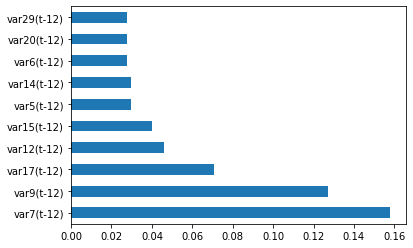

In [126]:
feat_importances = pd.Series(rf_model3.feature_importances_, index=supervised3.iloc[:,0:35].columns)
feat_importances.nlargest(10).plot(kind='barh')

Las variables más relevantes son el costo real ('var7(t-12')), la demanda ('var9(t-12')), la suma total de generación de diferentes tipos de energía ('var17(t-12')), el día del mes ('var12(t-12')), el número de la semana en el año ('var15(t-12')), la cantidad de generación solar ('var5(t-12')), el día de la semana ('var14(t-12')), la cantidad de generación térmica ('var6(t-12')), los incidentes de insolación ('var20(t-12')) de los datos de clima, y la temperatura de la superficie de la tierra (TS) ('var29(t-12')) también de los datos de clima. En cada caso se consideraron las observaciones 12 horas antes de la hora target a predecir.

### 8. Reflexión


- ¿Por qué sería bueno utilizar un modelo como este para anticiparse a desvíos de precios de la energía?

El Sistema Eléctrico Nacional al parecer es el encargado de regular la generación, producción y transferencia de energía eléctrica en el país. Dentro de sus objetivos está programar la generación de electricidad para minimizar costos al mismo tiempo que se vela por proveer el acceso a sistemas de transmisión. De esta forma, cuando las empresas privadas no se ajustan a la generación y costos programados, deben pagar multas. Así, este sistema podría ayudar al Sistema Eléctrico Nacional para minimizar costos.

- ¿Qué casos de uso te imaginas podrían beneficiarse teniendo acceso a un modelo como este?

Además de ayudar al Sistema Eléctrico Nacional a reducir costos, también un modelo como este podría servir a las empresas privadas para detectar qué les está generando el desvío en sus propios compromisos programáticos. Otra posible aplicación se relaciona con que es posible que el desvío tenga una repercusión en cómo se distribuye la energía por parte del Coordinador Eléctrico Nacional, si es el caso, un modelo de este estilo podría servir para mantener una distribución óptima y eficiente al adelantarse al comportamiento de las empresas. Al igual que los bancos cuando detectan morosos, el Coordinador Eléctrico Nacional podría detectar aquellas subestaciones que faltan a su compromiso programático.